<a href="https://colab.research.google.com/github/EwaKiz/GraphNeuralNetworks/blob/main/JedenLek.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title install torch
# Enforce pytorch version 1.6.0
# import torch
# if torch.__version__ != '1.6.0':
!pip uninstall torch -y
!pip uninstall torchvision -y
#   !pip install torch==1.6.0
#   !pip install torchvision==0.7.0
!pip install torch==1.8.0 torchvision  -f https://download.pytorch.org/whl/cu111/torch_stable.html
# Check pytorch version and make sure you use a GPU Kernel
!python -c "import torch; print(torch.__version__)"
!python -c "import torch; print(torch.version.cuda)"
!python --version
!nvidia-smi

Found existing installation: torch 1.10.0+cu111
Uninstalling torch-1.10.0+cu111:
  Successfully uninstalled torch-1.10.0+cu111
Found existing installation: torchvision 0.11.1+cu111
Uninstalling torchvision-0.11.1+cu111:
  Successfully uninstalled torchvision-0.11.1+cu111
Looking in links: https://download.pytorch.org/whl/cu111/torch_stable.html
     |█████████████▌                  | 834.1 MB 2.4 MB/s eta 0:07:58tcmalloc: large alloc 1147494400 bytes == 0x557f6d86e000 @  0x7fd85f0ed615 0x557f336354cc 0x557f3371547a 0x557f336382ed 0x557f33729e1d 0x557f336abe99 0x557f336a69ee 0x557f33639bda 0x557f336abd00 0x557f336a69ee 0x557f33639bda 0x557f336a8737 0x557f3372ac66 0x557f336a7daf 0x557f3372ac66 0x557f336a7daf 0x557f3372ac66 0x557f336a7daf 0x557f3363a039 0x557f3367d409 0x557f33638c52 0x557f336abc25 0x557f336a69ee 0x557f33639bda 0x557f336a8737 0x557f336a69ee 0x557f33639bda 0x557f336a7915 0x557f33639afa 0x557f336a7c0d 0x557f336a69ee
     |█████████████████               | 1055.7 MB 11.8 MB/s

1.8.0+cu111
11.1
Python 3.7.12
Wed Nov  3 11:01:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    28W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                         

In [32]:
import torch
# pytorch_version = f"torch-{torch.__version__}+cu{torch.version.cuda.replace('.', '')}.html"
pytorch_version = 'torch-1.9.0+cu111.html'
!pip install --no-index torch-scatter -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-sparse -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-cluster -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html


In [33]:
from torch_geometric.data import InMemoryDataset
from tqdm import tqdm
from torch_geometric.data import Data

In [34]:
class CosmicGraph(InMemoryDataset):
    def __init__(self, root,dataset,out_name, transform=None, pre_transform=None):
        self.dataset = dataset
        self.out_name = out_name
        super(CosmicGraph,self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
        

    @property
    def raw_file_names(self):
        return []
    @property
    def processed_file_names(self):
        return [self.out_name]

    def download(self):
        pass
    
    def process(self):
        
        data_list = []

        # process by session_id
        grouped = self.dataset.groupby('CosmicId')
        for CosmicId, group in tqdm(grouped):
            group = group.reset_index(drop=True)
            node_features = group.loc[group.CosmicId==CosmicId,['gene_id','mutation_code_1','expression_cor','cancer census','MUT_TYPE_gain','MUT_TYPE_loss']].sort_values('gene_id').drop('gene_id',axis=1).values

            node_features = torch.FloatTensor(node_features)
            x = node_features

            # y = torch.FloatTensor([group["AUC"].values[0]])
            y = torch.FloatTensor([[group["AUC"].values[0]]])

            data = Data(x=x, edge_index=edge_index, y=y)
            data_list.append(data)
        
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [35]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import random

In [36]:
CellLineData = pd.read_csv('/content/drive/MyDrive/ABT_final.csv')
CellLineData=CellLineData[['GENE_SYMBOLS','CosmicId','mutation_code_1','0','cancer census','MUT_TYPE_gain','MUT_TYPE_loss']]
GenesSl = pd.read_csv('/content/drive/MyDrive/B2_top500_CL_druggable_genes_final.csv',encoding='latin-1')
Genes = list(CellLineData.GENE_SYMBOLS.unique())
GenesSl = GenesSl.loc[(GenesSl['geneA'].isin(Genes)) & (GenesSl['geneB'].isin(Genes))]
genes_encoder = LabelEncoder()
CellLineData['gene_id'] = genes_encoder.fit_transform(CellLineData.GENE_SYMBOLS)
GenesSl = pd.merge(GenesSl,CellLineData[['GENE_SYMBOLS','gene_id']].drop_duplicates(),left_on ='geneA',right_on='GENE_SYMBOLS',how='left').drop('GENE_SYMBOLS',axis=1)
GenesSl.rename(columns={"gene_id":"a_id"},inplace=True)
GenesSl = pd.merge(GenesSl,CellLineData[['GENE_SYMBOLS','gene_id']].drop_duplicates(),left_on ='geneB',right_on='GENE_SYMBOLS',how='left').drop('GENE_SYMBOLS',axis=1)
GenesSl.rename(columns={"gene_id":"b_id"},inplace=True)

In [37]:
nodes_1 = np.append(GenesSl.a_id.values,GenesSl.b_id.values)
nodes_2 = np.append(GenesSl.b_id.values,GenesSl.a_id.values)
edge_index = torch.tensor([nodes_1, nodes_2], dtype=torch.long)

In [38]:
CellLineData

,GENE_SYMBOLS,CosmicId,mutation_code_1,0,cancer census,MUT_TYPE_gain,MUT_TYPE_loss,gene_id
0,ABCB1,683665,0.0,5.869685,0,0.0,0.0,0
1,ABCB1,683667,0.0,3.265524,0,0.0,0.0,0
2,ABCB1,684052,0.0,2.758147,0,0.0,0.0,0
3,ABCB1,684055,0.0,3.089067,0,0.0,0.0,0
4,ABCB1,684057,0.0,2.912594,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...
371565,ZNF451,1660036,1.0,4.627502,0,0.0,0.0,364
371566,ZNF451,1674021,1.0,5.025006,0,0.0,0.0,364
371567,ZNF451,1723793,0.0,4.240690,0,0.0,0.0,364
371568,ZNF451,1723794,0.0,4.580327,0,0.0,0.0,364


In [39]:
response = pd.read_csv('/content/drive/MyDrive/drug_response_for_drug-cell_line_pairs.csv')

In [40]:
'''Filter by drug id '''
def FilterByDrug(dataset,drug_id):
  dataset = dataset.loc[dataset['DRUG_ID']==drug_id]
  return dataset

In [41]:
response_Dabrafenib = FilterByDrug(response,1373)
cell_line_data_resp = pd.merge(CellLineData,response_Dabrafenib[['COSMIC_ID','AUC']].drop_duplicates(),left_on ='CosmicId',right_on='COSMIC_ID',how='left').drop('COSMIC_ID',axis=1)
cell_line_data_resp.dropna(subset = ["AUC"], inplace=True)

In [42]:
'split data into training and test set'
cell_lines = list(cell_line_data_resp['CosmicId'].unique())
random.seed(3)
test = random.sample(cell_lines,100)
val = random.sample([x for x in cell_lines if x not in test],100)
train = [x for x in cell_lines if x not in test and x not in val]

In [12]:
906851 in train

False

In [43]:
label=[]
for i in range(len(cell_line_data_resp)):
  row = cell_line_data_resp.iloc[i]
  cl = row['CosmicId']
  if cl in test:
    label.append('test')
  elif cl in val:
    label.append('val')
  else:
    label.append('train')

In [44]:
cell_line_data_resp['label'] = label

In [45]:
def NormalizeExpression(dataframe,mean=0,std =0):
  genes = list(dataframe.GENE_SYMBOLS.unique())
  i = 1
  for gene in genes:
    sample = dataframe.loc[dataframe['GENE_SYMBOLS']==gene]
    train = sample.loc[sample['label']=='train']
    mean = train['0'].mean()
    std = train['0'].std()
    sample['expression_cor'] = (sample['0']-mean)/std
    if i == 1 :
      result = sample
    else:
      result = pd.concat([result,sample])
    i+=1
  return result

In [46]:
normalized = NormalizeExpression(cell_line_data_resp)

In [47]:
Test_set = normalized.loc[normalized['CosmicId'].isin(test)]
Train_set = normalized.loc[normalized['CosmicId'].isin(train)]
Validation_set = normalized.loc[normalized['CosmicId'].isin(val)]

In [48]:
expression = Train_set.pivot_table('expression_cor', ['CosmicId'], 'GENE_SYMBOLS').add_prefix('exp_')
mutation = Train_set.pivot_table('mutation_code_1', ['CosmicId'], 'GENE_SYMBOLS').add_prefix('mut_')
gain = Train_set.pivot_table('MUT_TYPE_gain', ['CosmicId'], 'GENE_SYMBOLS').add_prefix('gain_')
loss = Train_set.pivot_table('MUT_TYPE_loss', ['CosmicId'], 'GENE_SYMBOLS').add_prefix('loss_')
vector_rep = pd.merge(expression,mutation,on = "CosmicId")
vector_rep = pd.merge(vector_rep,gain,on = "CosmicId")
vector_rep = pd.merge(vector_rep,loss,on = "CosmicId")
vector_rep_train = pd.merge(response_Dabrafenib[['COSMIC_ID','AUC']].drop_duplicates(),vector_rep,right_on ='CosmicId',left_on='COSMIC_ID',how='left')
vector_rep_train.dropna(subset = ["exp_ABCB1"], inplace=True)

In [49]:
expression = Test_set.pivot_table('expression_cor', ['CosmicId'], 'GENE_SYMBOLS').add_prefix('exp_')
mutation = Test_set.pivot_table('mutation_code_1', ['CosmicId'], 'GENE_SYMBOLS').add_prefix('mut_')
gain = Test_set.pivot_table('MUT_TYPE_gain', ['CosmicId'], 'GENE_SYMBOLS').add_prefix('gain_')
loss = Test_set.pivot_table('MUT_TYPE_loss', ['CosmicId'], 'GENE_SYMBOLS').add_prefix('loss_')
vector_rep = pd.merge(expression,mutation,on = "CosmicId")
vector_rep = pd.merge(vector_rep,gain,on = "CosmicId")
vector_rep = pd.merge(vector_rep,loss,on = "CosmicId")
vector_rep_test = pd.merge(response_Dabrafenib[['COSMIC_ID','AUC']].drop_duplicates(),vector_rep,right_on ='CosmicId',left_on='COSMIC_ID',how='left')
vector_rep_test.dropna(subset = ["exp_ABCB1"], inplace=True)
vector_rep_test

,COSMIC_ID,AUC,exp_ABCB1,exp_ACE2,exp_ACHE,exp_ADORA1,exp_ADORA2B,exp_ADRA1A,exp_ADRA2B,exp_AKT1,exp_ANO1,exp_ANPEP,exp_APH1A,exp_APH1B,exp_ARID1A,exp_ARID1B,exp_ARID2,exp_ARID4A,exp_ARID4B,exp_ASCC3,exp_ASH1L,exp_ASXL1,exp_ATF7IP,exp_ATM,exp_ATP1A1,exp_ATP1A2,exp_ATR,exp_ATRX,exp_AUTS2,exp_AVPR2,exp_BACE1,exp_BCL2L1,exp_BCL2L10,exp_BCOR,exp_BIRC2,exp_BPTF,exp_BRAF,exp_BRCA1,exp_BRIP1,exp_CA1,...,loss_SLC29A1,loss_SLC6A4,loss_SLX4,loss_SMAD4,loss_SMARCA4,loss_SMC3,loss_SMC4,loss_SOAT1,loss_SOST,loss_SRCAP,loss_STEAP1,loss_TACR1,loss_TAF1,loss_TBXAS1,loss_TEP1,loss_TET2,loss_TFRC,loss_THRA,loss_TLR4,loss_TNC,loss_TNFRSF8,loss_TNFSF4,loss_TNNC1,loss_TP53,loss_TP53BP1,loss_TPR,loss_TRIM37,loss_TTF1,loss_TUBB4B,loss_UBA3,loss_UBR5,loss_UGCG,loss_UMPS,loss_USP36,loss_VWF,loss_WDR70,loss_XPNPEP1,loss_YEATS2,loss_ZBTB20,loss_ZNF451
13,687514,0.940797,-0.795813,6.750864,-1.348356,-0.507384,0.858196,-1.139359,-0.539454,-0.670917,0.312023,-0.571699,-0.279029,-1.313566,-1.004221,-0.201694,0.140703,1.153767,-0.936723,0.031886,-0.922144,-1.335071,0.383756,-0.426571,0.561121,-1.351629,0.454086,0.740559,-0.153443,-0.766455,1.576346,-0.223903,-0.496992,1.397938,0.093870,0.034423,0.713784,0.708052,1.223724,-0.308725,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,687563,0.929480,-0.436656,-0.408545,0.233556,2.160566,0.351251,-0.952091,0.522925,-0.370882,-0.463191,-0.211496,1.112712,0.798567,-1.190600,-1.307199,-0.521974,-0.666628,0.438484,-1.113651,0.602878,-0.809396,-1.006598,-0.853497,-1.207747,1.418919,0.580894,0.526905,-0.701879,-0.440817,0.293079,0.733459,-0.477606,-1.427385,-0.446230,0.101863,-1.157947,-0.430523,-0.866720,0.008396,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,687804,0.986062,-0.576246,-0.395293,0.685969,1.306140,-1.212135,0.272033,-0.057714,0.141770,-0.671072,-0.530651,-1.094255,-0.671018,1.710095,1.180384,1.069085,-0.371779,1.200086,0.242445,1.515254,0.093265,0.079861,0.490471,1.067641,-0.850431,-0.612285,1.874295,1.178846,-0.179135,2.159313,-0.364359,-0.621672,1.875189,-1.385692,0.780545,-0.032411,0.983732,0.962647,-0.053273,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32,687812,0.970363,-0.407134,0.302041,-0.569647,-0.444363,-0.002900,-0.767819,0.800654,-1.433001,0.020576,-0.429900,0.963898,-0.196901,0.021789,-0.477380,0.291777,0.901228,1.544993,-1.259742,0.354537,1.266232,-0.692246,0.287597,-1.269117,0.094093,-0.128215,0.147089,-0.899760,-0.834839,0.271643,-0.497657,-0.470703,-0.973290,0.672146,0.876057,-0.131739,-1.399480,-0.352010,-0.235992,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37,687829,0.945158,-0.769827,-0.436544,-1.744371,0.028044,-0.583775,-2.015895,0.587347,1.260093,-0.391733,-0.189984,-0.714687,2.609823,1.279121,0.083797,0.303480,0.220517,-0.170499,0.775564,-1.260783,2.199182,0.646782,0.607739,-1.076049,-1.485002,-0.563865,0.759282,-0.103964,-0.244284,0.182616,-0.374443,-0.035760,1.242763,1.398347,0.223538,1.286942,1.084581,-0.274262,-0.489478,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,1331033,0.995324,-0.352761,-0.171732,1.592927,-0.286210,-1.546369,1.061814,-0.501232,-0.596108,-0.480727

In [50]:
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, ParameterGrid, RandomizedSearchCV, ParameterSampler
from numpy import linspace 
from numpy import sqrt
from numpy import corrcoef
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from scipy.stats import norm , truncnorm

In [ ]:
#xgboost



lower, upper = 0, 10
mu, sigma = 0.3, 0.2

flag = True



X_train = vector_rep_train.drop(['AUC','COSMIC_ID'],axis=1)
y_train = vector_rep_train['AUC']
X_test = vector_rep_test.drop(['AUC','COSMIC_ID'],axis=1)
y_test = vector_rep_test['AUC']

        # Instantiate the model
xgboost = xgb.XGBRegressor(seed = 2, objective = 'reg:squarederror', n_jobs = 4, booster = 'gbtree')
# Hyperparamter tuning on trainig set
param_test1 = {'max_depth':[2,3,4,5,6,7,8],
            'subsample':[0.5,1],
            'learning_rate':truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma),
            'n_estimators' : [25,50 ,75, 101,100,102],
            'reg_lambda' :[0., 0.5,1., 5]
        }



        # Instatiate grid search object
grid = RandomizedSearchCV(estimator = xgboost, param_distributions = param_test1,
                    scoring="neg_mean_squared_error",
                    cv=5,
                    n_jobs = 4,
                    refit=True,
                    n_iter = 50,
                    random_state = 2)

#Train the grid (compute cross validation for 50 parameter combinations)
try:
    grid.fit(X_train, y_train)
except ValueError:
    i+= 1
    flag = False
    glob = False
    print('upss  lek: ' + str(drug)+' random state: ' + str(random_state)+ ' seed: '+str(seeds[i])
          + 'proba nr: ' +str(num))
    rejects.append(drug)

if flag:

    best_model_test_predictions = grid.predict(X_test)
    best_model_train_predictions = grid.predict(X_train)

    #y_test
    RMSE_test = sqrt(mean_squared_error(y_test, best_model_test_predictions))
    corr_test = corrcoef(y_test, best_model_test_predictions)[0][1]
    # if isnan(corr_test)==True:
    #     corr_test = 0

    #y_train
    RMSE_train = sqrt(mean_squared_error(y_train, best_model_train_predictions))
    corr_train = corrcoef(y_train , best_model_train_predictions)[0][1]




In [ ]:
corr_train, RMSE_train,corr_test, RMSE_test

(0.9907310733263157,
 0.028790097944276245,
 0.5459464313109172,
 0.1745090858526683)

In [ ]:
#elatsic_net for each drug 

X_train = vector_rep_train.drop(['AUC','COSMIC_ID'],axis=1)
y_train = vector_rep_train['AUC']
X_test = vector_rep_test.drop(['AUC','COSMIC_ID'],axis=1)
y_test = vector_rep_test['AUC']

# Hyperparamter tuning on trainig set
# Instantiate the model
elastic_net = ElasticNet(random_state= 2, tol = 1)
# Instanitiate scaler
scaler = StandardScaler()
# Initiate pipeline
pipeline = Pipeline([
        ("scaler", scaler),
        ("estimator", elastic_net)
        ])
param_grid = {"estimator__alpha": [0.001, 0.01, 0.1, 1.],
            "estimator__l1_ratio": [0., 0.25, 0.5, 0.75, 1.]}
# Instatiate grid search object
grid = GridSearchCV(pipeline, param_grid,
                scoring="neg_mean_squared_error",
                cv=5,
                refit=True)
grid.fit(X_train, y_train)
#second param_grid ( only if alpha !=1)
alpha = grid.best_params_['estimator__alpha']
if alpha != 1:
    param_grid = {"estimator__alpha": list(linspace(alpha, 10*alpha,4)),
            "estimator__l1_ratio": [0., 0.25, 0.5, 0.75, 1.]}
    grid = GridSearchCV(pipeline, param_grid,
                scoring="neg_mean_squared_error",
                cv=5,
                refit=True)


# Train the grid (compute cross validation for every parameter combination)
grid.fit(X_train, y_train)
print(grid.best_params_)


best_model_test_predictions = grid.predict(X_test)
best_model_train_predictions = grid.predict(X_train)

#y_test
RMSE_test = sqrt(mean_squared_error(y_test, best_model_test_predictions))

corr_test = corrcoef(y_test, best_model_test_predictions)[0][1]


#y_train
RMSE_train = sqrt(mean_squared_error(y_train, best_model_train_predictions))

corr_train = corrcoef(y_train , best_model_train_predictions)[0][1]




{'estimator__alpha': 0.04, 'estimator__l1_ratio': 0.25}


In [ ]:
corr_train, RMSE_train,corr_test, RMSE_test

(0.7710332129874308,
 0.12111072494374298,
 0.5653321234445876,
 0.17079064909733452)

In [ ]:
min(grid.best_estimator_['estimator'].coef_)

-0.035662322964778566

In [ ]:
grid.best_estimator_['estimator'].coef_[99]

-0.035662322964778566

In [ ]:
list(grid.best_estimator_['estimator'].coef_).index(max(grid.best_estimator_['estimator'].coef_))

18

In [ ]:
X_train.columns[99]

'exp_EDNRB'

In [51]:
Train_graphs = CosmicGraph('',Train_set,'Train_set_graph.dataset')

In [52]:
Test_graphs = CosmicGraph('',Test_set,'Test_set_graph1.dataset')
Validation_graphs = CosmicGraph('',Validation_set,'Validation_set_graph1.dataset')

In [53]:
d = Train_graphs[0]
print(d.y)

tensor([[0.9168]])


In [54]:
Test_graphs.num_classes

100

In [23]:
data = Train_graphs
number_of_classes=655

In [ ]:
m = torch.nn.Dropout(p=0.2)
input = torch.randn(20, 16)
output = m(input)

In [24]:
!pip install ray[rllib]==0.8.1 

In [25]:
# import torchvision
# import torchvision.transforms as transforms
import ray
from ray import tune
from ray.tune import track
from functools import partial
import os

In [26]:
from torch.nn import Linear
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp, global_add_pool as gdp
embedding_size = 64

class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.conv1 = GCNConv(data.num_features, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)
        # Output layer
        self.out = Linear(embedding_size, 1)

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.conv1(x, edge_index)
        hidden = F.relu(hidden)
        #hidden = F.relu(hidden)
        # Other Conv layers
        hidden = self.conv2(hidden, edge_index)
        hidden = F.relu(hidden)

        # Other Conv layers
        hidden = self.conv3(hidden, edge_index)
        hidden = F.relu(hidden)
          
        # Global Pooling (stack different aggregations)
        # hidden = torch.cat([gap(hidden, batch_index), 
        #                     gmp(hidden, batch_index)], dim=1)
        hidden = gmp(hidden, batch_index)
        # print(hidden.shape)
        # Apply a final (linear) classifier.
        
        out = self.out(hidden)

        return out, hidden

model = GCN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (conv1): GCNConv(5, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=64, out_features=1, bias=True)
)
Number of parameters:  8769


In [27]:
from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

In [28]:
def train():
    # Enumerate over the data
    epoch_loss = 0
    i = 0
    for batch in train_loader:
      # Use GPU
      i+=1
      batch.to(device)
        
      # Reset gradients
      optimizer.zero_grad() 
      # Passing the node features and the connection info
      pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch) 
      
      # Calculating the loss and gradients
      loss = loss_fn(pred, batch.y)  
      epoch_loss += loss.item()    
      loss.backward()  
      # Update using the gradients
      optimizer.step()
    epoch_loss = epoch_loss/i   
    return epoch_loss


def train_val():
    # Enumerate over the data
    epoch_loss = 0
    i = 0
    for batch in val_loader:
      # Use GPU
      i+=1
      batch.to(device)
        
      # Reset gradients
      optimizer.zero_grad() 
      # Passing the node features and the connection info
      pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch) 
      
      # Calculating the loss and gradients
      loss = loss_fn(pred, batch.y)  
      epoch_loss += loss.item()    
      loss.backward()  
      # Update using the gradients
      optimizer.step()
    epoch_loss = epoch_loss/i   
    return epoch_loss


In [ ]:

# Root mean squared error
model = GCN()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.25)  

# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Wrap data in a data loader
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 16
train_loader = DataLoader(Train_graphs, 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
val_loader = DataLoader(Validation_graphs, 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(Test_graphs, 
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)



print("Starting training...")
losses = []
for epoch in range(500):
    loss = train()
    losses.append(loss)
    if epoch % 100 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")

In [76]:

import matplotlib.pyplot as plt

In [71]:
# losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
import seaborn as sns
loss_indices = [i for i,l in enumerate(losses)] 
plt = sns.lineplot(loss_indices, losses)
plt

In [77]:
def train_graphs(config, checkpoint_dir=None, data_dir=None):
  
  results = {}
  results['config'] = config
  model = GCN()
  
  loss_fn = torch.nn.MSELoss()
  print(config["lr"])
  optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"], weight_decay=config["l2"])  
  track.init()
  # # Use GPU for training
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model = model.to(device)

  # # Wrap data in a data loader
  data_size = len(data)
  print(data_size)
  # # NUM_GRAPHS_PER_BATCH = config["batch_size"]
  NUM_GRAPHS_PER_BATCH = 32
  train_loader = DataLoader(Train_graphs, 
                      batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
  val_loader = DataLoader(Validation_graphs, 
                      batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
  test_loader = DataLoader(Test_graphs, 
                          batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
  losses=[]
  val_losses=[]
  for epoch in range(10):
    
    epoch_loss = 0
    i = 0
    for batch in train_loader:
      # Use GPU
      i+=1
      batch.to(device)
        
      # Reset gradients
      optimizer.zero_grad() 
      # Passing the node features and the connection info
      pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch) 
      
      # Calculating the loss and gradients
      loss = loss_fn(pred, batch.y)  
      epoch_loss += loss.item()    
      loss.backward()  
      # Update using the gradients
      optimizer.step()
    epoch_loss = epoch_loss/i   
    losses.append(epoch_loss)

    epoch_loss = 0
    i = 0
    for batch in val_loader:
      # Use GPU
      i+=1
      batch.to(device)
        
      # Reset gradients
      optimizer.zero_grad() 
      # Passing the node features and the connection info
      pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch) 
      
      # Calculating the loss and gradients
      loss = loss_fn(pred, batch.y)  
      epoch_loss += loss.item()    
      loss.backward()  
      # Update using the gradients
      optimizer.step()
    epoch_loss = epoch_loss/i
    val_losses.append(epoch_loss)
    # loss_val = train_val()
    
    # with tune.checkpoint_dir(epoch) as checkpoint_dir:
    #   path = os.path.join(checkpoint_dir, "checkpoint")
    #   torch.save((net.state_dict(), optimizer.state_dict()), path)
    track.log(loss=epoch_loss, accuracy=epoch_loss)
  print(config)
  loss_indices = [i for i,l in enumerate(losses)] 
  sns.lineplot(loss_indices, losses)
  plt.show()
  loss_indices = [i for i,l in enumerate(val_losses)] 
  sns.lineplot(loss_indices, val_losses)
  plt.show()

In [30]:
config = {
    "l2": tune.loguniform(1e-4, 1e-1),
    "lr": tune.loguniform(1e-4, 1e-1),
    # "batch_size": tune.choice([8,16,32,64])
}

In [ ]:
tune.sample_from(lambda _: 2**np.random.randint(2, 9))

In [ ]:

analysis = tune.run(train_graphs, 
                        config=config, 
                        num_samples=5,
                        # local_dir=global_experiment_dir,
                        # resources_per_trial={"cpu": 1, "gpu": 0.48},
                        max_failures=3,
                        verbose=0)

2021-11-04 07:48:46,913	WARNING worker.py:1063 -- Warning: The actor WrappedFunc has size 160351572 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2021-11-04 07:48:47,091	WARNING util.py:136 -- The `start_trial` operation took 3.5334043502807617 seconds to complete, which may be a performance bottleneck.
2021-11-04 07:48:50,269	WARNING worker.py:1063 -- Warning: The actor WrappedFunc has size 160351572 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2021-11-04 07:48:50,445	WARNING util.py:136 -- The `start_trial` operation took 3.346251964569092 seconds to complete, which may be a performance bottleneck.


In [70]:
res = analysis.dataframe
res


<bound method Analysis.dataframe of <ray.tune.analysis.experiment_analysis.ExperimentAnalysis object at 0x7f759fedd9d0>>

In [ ]:
scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=500,
        grace_period=1,
        reduction_factor=2)
reporter = CLIReporter(
        # parameter_columns=["l1", "l2", "lr", "batch_size"],
        metric_columns=["loss", "accuracy", "training_iteration"])

In [ ]:
result = tune.run(
    partial(train_cifar, data_dir=None),
    # resources_per_trial={"cpu": 8, "gpu": gpus_per_trial},
    config=config,
    # num_samples=num_samples,
    scheduler=scheduler,
    progress_reporter=reporter,
    fail_fast="raise",
    checkpoint_at_end=False)

2021-10-28 11:42:11,745	WARNING experiment.py:303 -- No name detected on trainable. Using DEFAULT.
2021-10-28 11:42:11,748	INFO registry.py:67 -- Detected unknown callable for trainable. Converting to class.
2021-10-28 11:42:12,874	WARNING callback.py:117 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`
2021-10-28 11:42:15,933	ERROR ray_trial_executor.py:600 -- Trial DEFAULT_178ba_00000: Unexpected error starting runner.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/ray/tune/ray_trial_executor.py", line 590, in start_trial
    return self._start_trial(trial, checkpoint, train=train)
  File "/usr/local/lib/python3.7/dist-packages/ray/tune/ray_trial_executor.py", line 465, in _start_trial
    runner = self._setup_remote_runner(trial)
  File "/usr/local/lib/python3.7/dist-package

== Status ==
Memory usage on this node: 1.6/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 256.000: None | Iter 128.000: None | Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 1.0/2 CPUs, 0/0 GPUs, 0.0/7.39 GiB heap, 0.0/3.69 GiB objects
Result logdir: /root/ray_results/DEFAULT_2021-10-28_11-42-12
Number of trials: 1/1 (1 ERROR)
+---------------------+----------+-------+--------------+-------------+-----------+
| Trial name          | status   | loc   |   batch_size |          l2 |        lr |
|---------------------+----------+-------+--------------+-------------+-----------|
| DEFAULT_178ba_00000 | ERROR    |       |            2 | 0.000505616 | 0.0230726 |
+---------------------+----------+-------+--------------+-------------+-----------+
Number of errored trials: 1
+---------------------+--------------+----------------------------------------------------------------

TuneError: ignored

In [ ]:
preds = []
reals = []
# Analyze the results for one batch
# test_batch = next(iter(test_loader))
# i=0
with torch.no_grad():
    for test_batch in train_loader:
      test_batch.to(device)
      pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch)
      reals.extend(test_batch.y.tolist()) 
      preds.extend(pred.tolist())
df = pd.DataFrame()
df["y_real"] = reals
df["y_pred"] = preds
df["y_real"] = df["y_real"].apply(lambda row: row[0])
df["y_pred"] = df["y_pred"].apply(lambda row: row[0])
correlation = df.corr(method='pearson')
correlation

,y_real,y_pred
y_real,1.0,NaN
y_pred,NaN,NaN


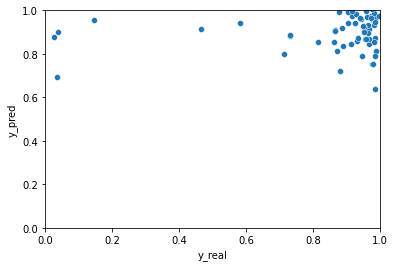

In [ ]:

plt = sns.scatterplot(data=df, x="y_real", y="y_pred")
plt.set(xlim=(0, 1))
plt.set(ylim=(0, 1))
plt

In [ ]:
correlation = df.corr(method='pearson')
correlation

,y_real,y_pred
y_real,1.00000,0.80932
y_pred,0.80932,1.00000


In [ ]:
from sklearn.metrics import mean_squared_error as mse
from math import sqrt
print(sqrt(mse(df['y_real'],df['y_pred'])))

0.018824875487310353


In [ ]:
preds = []
reals = []
# Analyze the results for one batch
# test_batch = next(iter(test_loader))
# i=0
with torch.no_grad():
    for test_batch in test_loader:
      test_batch.to(device)
      pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch)
      reals.extend(test_batch.y.tolist()) 
      preds.extend(pred.tolist())
df = pd.DataFrame()
df["y_real"] = reals
df["y_pred"] = preds
df["y_real"] = df["y_real"].apply(lambda row: row[0])
df["y_pred"] = df["y_pred"].apply(lambda row: row[0])
correlation = df.corr(method='pearson')
correlation

,y_real,y_pred
y_real,1.000000,0.153272
y_pred,0.153272,1.000000


In [ ]:
df

,y_real,y_pred
0,0.940797,0.719177
1,0.846241,0.992057
2,0.955734,0.640758
3,0.868315,0.990559
4,0.978875,0.855068
...,...,...
95,0.964800,0.697250
96,0.715180,0.491895
97,0.905502,0.874358
98,0.960625,1.104769
